# 10 Sklearn Features I Sincerely Hope You Learn After Using It For a Year
## TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@psco?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pineapple Supply Co.</a>
        on 
        <a href='https://www.pexels.com/photo/photo-of-three-pineapples-surrounded-by-balloons-1071882/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

# Setup

In [1]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PowerTransformer

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [2]:
from sklearn.datasets import *

X, y = make_regression(n_samples=1000000, n_features=10)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=1121218, test_size=0.2
)

# Introduction

# 1. FunctionTransformer

I love Sklearn pipelines. They make your code modular, easy to read and maintain. They are also designed specifically to prevent data leakage, which when unnoticed, can break your model by giving false optimistic results. 

Even though Sklearn has many preprocessing transformers that can be put into a pipeline, they aren't enough for any imaginable preprocessing scenario. Even if you have a single step that is not inside a pipeline, the whole idea of atomic, single-operation pipelines breaks down. 

That's why you should wrap all your custom functions inside `FunctionTransformer` which can convert them into an Sklearn-compatible transformer. The only requirement is that the function should accept a feature array (X) and an optional target array and return them after preprocessing is done. 

### 💻Demo

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


def reduce_memory(X: pd.DataFrame, y=None):
    """Simple function to reduce memory usage by casting numeric columns to float32."""
    num_cols = X.select_dtypes(incluce=np.number).columns
    for col in num_cols:
        X[col] = X.astype("float32")

    return X, y


ReduceMemoryTransformer = FunctionTransformer(reduce_memory)

# Plug into a pipeline
make_pipeline(SimpleImputer(), ReduceMemoryTransformer)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('functiontransformer',
                 FunctionTransformer(func=<function reduce_memory at 0x000001B75E036CA0>))])

### 📚Documentation
**FunctionTransformer** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer)

# 2. User-defined transformers

Building on the last section, some custom data cleaning operations can't be performed inside a simple function. 

For example, one of the most common operations done during cleaning is scaling skewed features so that they are normally distributed. Usually, people use logarithmic transformers like `PowerTransformer` but they have a catch. If a feature contains zeros, the logarithm can't handle it and raise an error. 

As a workaround, people just add 1 to the feature vector and then perform a transform. If they need the original vector, they call the exponential function on the feature and subtract 1 - problem solved. 

Of course, this operation isn't built into Sklearn and you can't perform it inside a simple Python function. That's where you elegantly fix this dilemma with custom transformers. Below is a transformer that does exactly what I described:

### 💻Demo

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer


class CustomLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._estimator = PowerTransformer()

    def fit(self, X, y=None):
        X_copy = np.copy(X) + 1
        self._estimator.fit(X_copy)

        return self

    def transform(self, X):
        X_copy = np.copy(X) + 1

        return self._estimator.transform(X_copy)

    def inverse_transform(self, X):
        X_reversed = self._estimator.inverse_transform(np.copy(X))

        return X_reversed - 1

The class should inherit from `BaseEstimator` and `TransformerMixin` classesa and they can be plugged into a pipeline. You write less code and there is less chance of data leakage.

If you want to learn more about this method, I have a separate article on this type of custom transformers, including the FunctionTransformer:

https://towardsdatascience.com/how-to-write-powerful-code-others-admire-with-custom-sklearn-transformers-34bc9087fdd?source=your_stories_page-------------------------------------

### 📚Documentation
**BaseEstimator** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html#sklearn.base.BaseEstimator).

**TransformerMixin** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html).

https://towardsdatascience.com/how-to-write-powerful-code-others-admire-with-custom-sklearn-transformers-34bc9087fdd?source=your_stories_page-------------------------------------

# 3. TransformedTargetRegressor

As we continue the discussion about pipelines and transformers for feature arrays (i.e. *X*), we left out transformations of the target array (*y*). 

Since features and target are separated before training, target requires calling extra preprocessing steps, which can't be included inside a pipeline. Well, at least, not with traditional pipelines. 

TransformedTargetRegressor is a class that accepts both a regressor pipeline on features and separate preprocessing steps for the target array. 

### 💻Demo

In [6]:
from sklearn.compose import TransformedTargetRegressor

reg_lgbm = lgbm.LGBMRegressor()

final_estimator = TransformedTargetRegressor(
    regressor=reg_lgbm, transformer=CustomLogTransformer()
)

final_estimator.fit(X_train, y_train)

TransformedTargetRegressor(regressor=LGBMRegressor(),
                           transformer=CustomLogTransformer())

The `regressor` parameter accepts both regressors or pipelines that end with them. It also has `transformer` parameter for which you pass a transformation function to be applied on the target. If the transformation is simple like `np.log` but not a class, you can pass it to `func` argument. 

Then, calling `fit` will both transform the feature and target arrays and fits the regressor. Learn more about it in the documentation. 

### 📚Documentation

**TransformedTargetregressor** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor).

# 4. QuadraticDiscriminantAnalysis

![](https://miro.medium.com/proxy/1*utS0gTpSfjYPAJHCwuFGcg.png)

### 💻Demo

In [7]:
%%time

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X, y = make_classification(n_samples=1000000, n_features=100)
qda = QuadraticDiscriminantAnalysis().fit(X, y)

Wall time: 13.4 s


### 📚Documentation
**QuadraticDiscriminantAnalysis** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).

# 5. Voting Classifier/Regresssor

In a single project, you often end up with a few tuned models with similar performances. That's where a voting ensemble can collectively use those models to increase the performance even more. A voting classifier takes the majority vote of several other classifiers as a final prediction. If the classes are probabilities or predictions are continuous, the predictions are simply averaged.

The reason why this method works pretty well is baked into probability theory. In short, three classifiers with 0.6, 0.7, 0.8 accuracies will end up outperforming three classifiers with 0.8 accuracy when combined. If you don't believe, read [this article](https://mlwave.com/kaggle-ensembling-guide/) from MLWave.

Sklearn provides two handy classes that implements this operation. You simply need to pass a list of classifiers or regressors and it takes care of the rest.

### 💻Demo

In [ ]:
from sklearn.ensemble import VotingClassifier

X, y = make_classification(n_samples=1000)

ensemble = VotingClassifier(
    estimators=[
        ("xgb", xgb.XGBClassifier(eval_metric="auc")),
        ("lgbm", lgbm.LGBMClassifier()),
        ("cb", cb.CatBoostClassifier(verbose=False)),
    ],
    voting="soft",
    # n_jobs=-1,
)

_ = ensemble.fit(X, y)

I set `voting` to soft, indicating that I want the predictions to be probabilities. There is also `weights` argument which you can use to assign different coefficients for more accurate models.

### 📚Documentation
**VotingClassifier** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier).

**VotingRegressor** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html).

# 6. Stacking Classifier/Regressor

### 💻Demo

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=1000)

ensemble = StackingClassifier(
    estimators=[
        ("xgb", xgb.XGBClassifier(eval_metric="auc")),
        ("lgbm", lgbm.LGBMClassifier()),
        ("cb", cb.CatBoostClassifier(verbose=False)),
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    passthrough=False
    # n_jobs=-1,
)

_ = ensemble.fit(X, y)

### 📚Documentation
**StackingClassifier** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

**StackingRegressor** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html).

# 7. LocalOutlierFactor

### 💻Demo

In [10]:
%%time

import umap  # pip install umap
from sklearn.neighbors import LocalOutlierFactor

X, y = make_classification(n_samples=5000, n_classes=2, n_features=10)
X_reduced = umap.UMAP(n_components=2).fit_transform(X, y)

lof = LocalOutlierFactor()
labels = lof.fit_predict(X_reduced, y)

np.where(labels == -1)

Wall time: 17.8 s


(array([ 119,  155,  303,  331,  333,  407,  418,  549,  599,  664,  795,
         811,  836, 1008, 1131, 1181, 1186, 1353, 1437, 1710, 1763, 1865,
        1909, 2054, 2075, 2138, 2333, 2379, 2407, 2486, 2507, 2728, 2968,
        3092, 3262, 3271, 3280, 3289, 3311, 3477, 3899, 3929, 3975, 4301,
        4358, 4442, 4522, 4561, 4621, 4631, 4989], dtype=int64),)

### 📚Documentation
**LocalOutlierFactor** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor).

# 8. QuantileTransformer

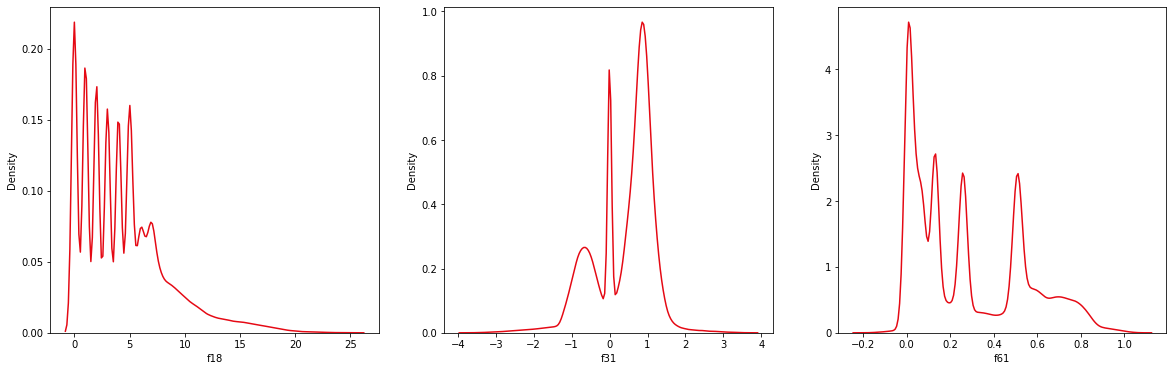

In [11]:
tps_sep = dt.fread("data/train.csv").to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
crazy_features = ["f18", "f31", "f61"]

for ax, f_name in zip(axes.flatten(), crazy_features):
    sns.kdeplot(tps_sep[f_name], ax=ax, color="#E50914")

### 💻Demo

In [12]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer().fit(tps_sep[crazy_features])

tps_sep.loc[:, crazy_features] = qt.transform(tps_sep[crazy_features])

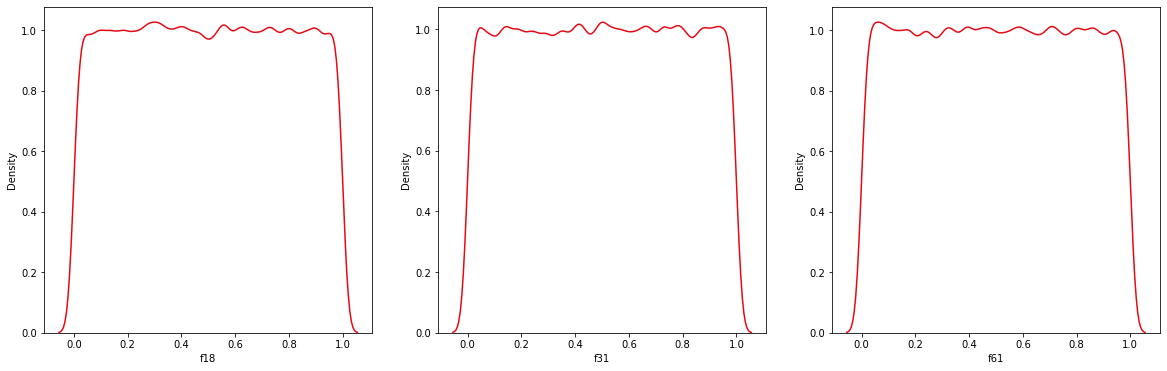

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
crazy_features = ["f18", "f31", "f61"]

for ax, f_name in zip(axes.flatten(), crazy_features):
    sns.kdeplot(tps_sep[f_name], ax=ax, color="#E50914")

### 📚Documentation
**QuantileTransformer** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer).

# 9. PCA + tSNE

### 💻Demo

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tps_october = dt.fread("data/train_oct.csv").to_pandas()
tps_october.shape

(1000000, 287)

In [15]:
X, y = tps_october.drop("target", axis=1), tps_october[["target"]].values.flatten()

In [16]:
%%time
manifold_pipe = make_pipeline(QuantileTransformer(), PCA(n_components=30), TSNE())

reduced_X = manifold_pipe.fit_transform(X, y)

Wall time: 4h 27min 46s


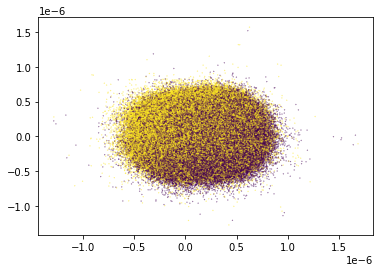

In [25]:
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=y, s=0.05);

In [18]:
%%time
manifold_pipe = make_pipeline(QuantileTransformer(), PCA(n_components=30))

X_pca = manifold_pipe.fit_transform(X, y)
embedding = umap.UMAP(n_components=2).fit(X_pca, y)

Wall time: 14min 27s


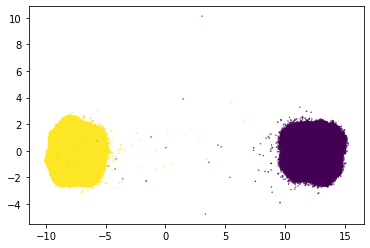

In [26]:
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], c=y, s=0.05);

### 📚Documentation
**PCA** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

**tSNE** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE).

**UMAP** - [link](https://umap-learn.readthedocs.io/).

In [ ]:
%%time

from sklearn.metrics import roc_auc_score

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.4, random_state=1121218
)

X_train_pca = manifold_pipe.fit_transform(X_train, y_train)
X_valid_pca = manifold_pipe.transform(X_valid)

embedding = umap.UMAP()
X_train_u = embedding.fit_transform(X_train_pca)
X_valid_u = embedding.transform(X_valid_pca)

qda = QuadraticDiscriminantAnalysis().fit(X_train_u, y_train)
preds = qda.predict_proba(X_valid_u)

In [ ]:
roc_auc_score(y_valid, preds[:, 1])

# 10. HTML Estimator Representation

In [21]:
cat_pipe = Pipeline(
    steps=[("impute", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder())]
)

num_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("transform", QuantileTransformer()),
    ]
)

composed = ColumnTransformer(
    transformers=[
        ("cat_pipe", cat_pipe, make_column_selector(dtype_exclude=np.number)),
        ("num_pipe", num_pipe, make_column_selector(dtype_include=np.number)),
    ]
)

giant_pipeline = make_pipeline(
    composed,
    lgbm.LGBMRegressor(n_estimators=10000, learning_rate=0.01, device_type="gpu"),
)

In [22]:
giant_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6D8BD9310>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('transform',
                                                                   QuantileTransformer())]),


### 💻Demo

```python
from sklearn import set_config

set_config(display="diagram")
```

![](images/pipeline.png)

### 📚Documentation
**sklearn.set_config** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.set_config.html).

**sklearn.utils.estimator_html_repr** - [link](https://scikit-learn.org/stable/modules/generated/sklearn.utils.estimator_html_repr.html)

# Summary